In [1]:
import os
import sys
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import optuna
import joblib
import math
import ast
import logging
from pathlib import Path  
from msig import Motif, NullModel

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Load YAML configuration
config_path = "config.yaml" 
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

BASE_DIR = Path(config["base_dir"]).resolve()

RESULTS_DIR = BASE_DIR / config["results_dir"]
IMAGES_DIR = BASE_DIR / config["images_dir"]
DATA_DIR = BASE_DIR / config["data_dir"]
DATASET_PATH = BASE_DIR / config["dataset_path"]
RESULTS_MOTIF_DIR = BASE_DIR / config["results_motif_dir"]

VARIABLES = config["variables"]
NORMALIZE_FLAGS = config["normalize_flags"]
STUMPY_EXCL_ZONE_DENOM = config["stumpy_excl_zone_denom"]
TOP_K_MP = config["top_k_mp"]
INCLUDE = config["include"]
NORMALIZE = config["normalize"]
SUBSEQUENCES_LENGTHS = config["subsequences_lengths"]
NTOP_MOTIFS = config["ntop_motifs"]
MOTIF_SIZE = config["motif_size"]
LOOKBACK_PERIOD = config["lookback_period"]
STEP = config["step"]
FORECAST_PERIOD = config["forecast_period"]

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")
print(f"Dataset path: {DATASET_PATH}")

if '__file__' in globals():
    # For standalone scripts
    base_dir = Path(__file__).parent.resolve()
else:
    # For Jupyter or interactive environments
    base_dir = Path(os.getcwd()).resolve()

sys.path.append(str(base_dir / "../"))

Results will be saved in: /home/mgsilva/motifpred/results/household
Images will be saved in: /home/mgsilva/motifpred/images/household
Data will be accessed from: /home/mgsilva/motifpred/data/household
Dataset path: /home/mgsilva/motifpred/data/household/data_5min_resampled_globalactive_reactive.csv


In [2]:
mp_stats_table = pd.read_csv(
    RESULTS_DIR / f"mp_stats_table_normalized_{NORMALIZE}_top_{TOP_K_MP}.csv"
)
mp_stats_table = mp_stats_table[mp_stats_table["m"] == MOTIF_SIZE]
top_motifs = mp_stats_table.sort_values(by=["#Matches", "ID"], ascending=[False, True]).head(NTOP_MOTIFS)
top_motifs = top_motifs[["m", "Indices"]]

In [3]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [4]:
#load data as 
data_df = pd.read_csv(DATASET_PATH, index_col=0).astype(float)
data_df = data_df[VARIABLES]
data = data_df.values.T
data

array([[1.2944, 1.3644, 1.4672, ..., 0.7808, 0.7676, 0.634 ],
       [0.    , 0.0776, 0.2188, ..., 0.1644, 0.1492, 0.0608]])

In [5]:
# Set global style for scientific plots
plt.rcParams.update({
    "font.family": "serif",  # Use a serif font for better readability in papers
    "font.size": 14,         # Increase font size for clarity
    "axes.titlesize": 16,    # Larger title font size
    "axes.labelsize": 14,    # Axis label size
    "xtick.labelsize": 12,   # Tick size for x-axis
    "ytick.labelsize": 12,   # Tick size for y-axis
    "legend.fontsize": 12,   # Legend font size
    "figure.figsize": (6, 4) # Standard paper figure size
})

num_vars = data.shape[0]  # Number of variables in the dataset

for i, row in top_motifs.iterrows():
    motif_indices = sorted(ast.literal_eval(row["Indices"]))

    # Create subplots for each variable
    fig, axs = plt.subplots(num_vars, 2, figsize=(8, 3 * num_vars), dpi=300, gridspec_kw={'width_ratios': [1, 2]},  constrained_layout=True)

    if num_vars == 1:
        axs = np.expand_dims(axs, axis=0)  # Ensure it remains iterable for a single-variable case

    for var_idx in range(num_vars):
        motif_subsequences = []

        # Extract motif sequences for the current variable
        for indice in motif_indices:
            seq = data[var_idx, indice:indice + MOTIF_SIZE]
            if len(seq) == MOTIF_SIZE:  # Ensure valid motif length
                norm_seq = (seq - np.mean(seq)) / np.std(seq)
                motif_subsequences.append(norm_seq)

        if not motif_subsequences:
            print(f"Skipping motif {i} for variable {var_idx} due to empty subsequences.")
            continue

        motif_subsequences = np.array(motif_subsequences)

        # Plot normalized motif subsequences
        axs[var_idx, 0].plot(motif_subsequences.T, color="black", alpha=0.3, linewidth=1)
        axs[var_idx, 0].set_title(f"Normalized Subsequences", fontsize=16)
        axs[var_idx, 0].set_xlabel("Time", fontsize=14)
        axs[var_idx, 0].grid(True, linestyle="--", alpha=0.5)

        # Plot original time series with motif locations
        axs[var_idx, 1].plot(data[var_idx, : ], color="black", alpha=0.7, linewidth=1.5)
        for indice in motif_indices:
            axs[var_idx, 1].axvline(x=indice, color="red", linestyle="--", linewidth=1.2, alpha=0.5, 
                                    label="Motif Occurrence" if indice == motif_indices[0] else "")
        axs[var_idx, 1].set_title(f" Time Series ({VARIABLES[var_idx]})", fontsize=16)
        axs[var_idx, 1].set_xlabel("Time", fontsize=14)
        axs[var_idx, 1].grid(True, linestyle="--", alpha=0.5)

        # Add legend only once
        if len(motif_indices) > 0:
            axs[var_idx, 1].legend(loc="upper right", frameon=True)

    # Save as high-quality PNG or PDF
    plt.savefig(IMAGES_DIR / f"top_motif_{i}.png", dpi=300, bbox_inches="tight")
    plt.savefig(IMAGES_DIR / f"top_motif_{i}.pdf", bbox_inches="tight")  # Optional PDF for papers
    plt.close()


/tmp/ipykernel_288561/581482660.py:31: RuntimeWarning: invalid value encountered in divide
  norm_seq = (seq - np.mean(seq)) / np.std(seq)
/tmp/ipykernel_288561/581482660.py:31: RuntimeWarning: invalid value encountered in divide
  norm_seq = (seq - np.mean(seq)) / np.std(seq)
/tmp/ipykernel_288561/581482660.py:31: RuntimeWarning: invalid value encountered in divide
  norm_seq = (seq - np.mean(seq)) / np.std(seq)
/tmp/ipykernel_288561/581482660.py:31: RuntimeWarning: invalid value encountered in divide
  norm_seq = (seq - np.mean(seq)) / np.std(seq)


In [6]:
top_motifs

,m,Indices
5,24,"[8371, 9127, 4929, 31, 4614, 4351, 10979, 5233..."
17,24,"[2184, 2487, 2335, 11263, 15144, 2591, 7106, 9..."
1,24,"[9085, 15374, 14247, 15158, 13875, 1810, 1175,..."
7,24,"[7193, 7535, 603, 3812, 10530, 587, 7936, 6504..."
6,24,"[6921, 6647, 6474, 7243, 6366, 13436, 6935, 70..."


In [7]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.transformer_pytorch import Transformer
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test


test_losses_list = []
test_mae_list = []
test_rmse_list = []

# Loop through each of the top 10 motifs
for i, top_motif in top_motifs.iterrows():
    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i+1} with size {MOTIF_SIZE} and {len(motif_indexes)} indexes ")
    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "Transformer"
    model_name = "TransformerSeries"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3],
            "kwargs": {"log": True}
        },
        "d_model": {
            "type": "categorical",
            "args": [[64, 128, 256, 512]]
        },
        "n_heads": {
            "type": "categorical",
            "args": [[2, 4, 8, 16]]
        },
        "e_layers": {
            "type": "categorical",
            "args": [[1, 2, 3]]
        },
        "dim_feedforward": {
            "type": "categorical",
            "args": [[128, 256, 512]]
        },
        "dropout": {
            "type": "float",
            "args": [0.0, 0.5]
        },
        "batch_size": {
            "type": "categorical",
            "args": [[16, 32, 64, 128]]
        }
    }

    model_params_keys = ["d_model", "n_heads", "e_layers", "dim_feedforward", "dropout"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_series": X_series}
    #run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    # Plot predictions vs true values
    #epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    #plot_best_model_results_traindevtest( study.trials_dataframe(),
    #    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    #)    
    #plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")

Evaluating motif 6 with size 24 and 359 indexes 
X_series shape: torch.Size([2977, 576, 2])
X_indices shape: torch.Size([2977, 22, 1])
X_mask shape: torch.Size([2977, 576])
y shape: torch.Size([2977, 1])
Best epoch: 19
Test Loss: 1431.59814453125, Test MAE: 26.413354873657227, Test RMSE: 37.836463928222656
Evaluating motif 18 with size 24 and 358 indexes 
X_series shape: torch.Size([2974, 576, 2])
X_indices shape: torch.Size([2974, 20, 1])
X_mask shape: torch.Size([2974, 576])
y shape: torch.Size([2974, 1])
Best epoch: 87
Test Loss: 1293.6204833984375, Test MAE: 26.448455810546875, Test RMSE: 35.96693420410156
Evaluating motif 2 with size 24 and 298 indexes 
X_series shape: torch.Size([2987, 576, 2])
X_indices shape: torch.Size([2987, 17, 1])
X_mask shape: torch.Size([2987, 576])
y shape: torch.Size([2987, 1])
Best epoch: 36
Test Loss: 1148.8695068359375, Test MAE: 28.552406311035156, Test RMSE: 33.89497756958008
Evaluating motif 8 with size 24 and 279 indexes 
X_series shape: torch.Si

In [8]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.transformer_pytorch import Transformer
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test

test_losses_list = []
test_mae_list = []
test_rmse_list = []

# Loop through each of the top 10 motifs
for i, top_motif in top_motifs.iterrows():
    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i} with size {MOTIF_SIZE} and {len(motif_indexes)} indexes ")
    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "Transformer"
    model_name = "TransformerSeries_Masking"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3],
            "kwargs": {"log": True}
        },
        "d_model": {
            "type": "categorical",
            "args": [[64, 128, 256, 512]]
        },
        "n_heads": {
            "type": "categorical",
            "args": [[2, 4, 8, 16]]
        },
        "e_layers": {
            "type": "categorical",
            "args": [[1, 2, 3]]
        },
        "dim_feedforward": {
            "type": "categorical",
            "args": [[128, 256, 512]]
        },
        "dropout": {
            "type": "float",
            "args": [0.0, 0.5]
        },
        "batch_size": {
            "type": "categorical",
            "args": [[16, 32, 64, 128]]
        }
    }

    model_params_keys = ["d_model", "n_heads", "e_layers", "dim_feedforward", "dropout"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_series": X_series, "X_mask": X_mask}
    #run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    # Plot predictions vs true values
    #epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    #plot_best_model_results_traindevtest( study.trials_dataframe(),
    #    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    #)    
    #plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")


Evaluating motif 5 with size 24 and 359 indexes 
X_series shape: torch.Size([2977, 576, 2])
X_indices shape: torch.Size([2977, 22, 1])
X_mask shape: torch.Size([2977, 576])
y shape: torch.Size([2977, 1])
Best epoch: 248
Test Loss: 1460.6217041015625, Test MAE: 26.819963455200195, Test RMSE: 38.218082427978516
Evaluating motif 17 with size 24 and 358 indexes 
X_series shape: torch.Size([2974, 576, 2])
X_indices shape: torch.Size([2974, 20, 1])
X_mask shape: torch.Size([2974, 576])
y shape: torch.Size([2974, 1])
Best epoch: 69
Test Loss: 1462.035400390625, Test MAE: 27.654924392700195, Test RMSE: 38.236572265625
Evaluating motif 1 with size 24 and 298 indexes 
X_series shape: torch.Size([2987, 576, 2])
X_indices shape: torch.Size([2987, 17, 1])
X_mask shape: torch.Size([2987, 576])
y shape: torch.Size([2987, 1])
Best epoch: 17
Test Loss: 1171.263671875, Test MAE: 28.633983612060547, Test RMSE: 34.22372817993164
Evaluating motif 7 with size 24 and 279 indexes 
X_series shape: torch.Size([

Evaluating motif 6 with size 24 and 359 indexes 
X_series shape: torch.Size([2977, 576, 2])
X_indices shape: torch.Size([2977, 22, 1])
X_mask shape: torch.Size([2977, 576])
y shape: torch.Size([2977, 1])
Best epoch: 271
Test Loss: 1283.5745849609375, Test MAE: 26.159137725830078, Test RMSE: 35.82700729370117
Best hyperparameters: {'learning_rate': 1.2025578273989074e-05, 'd_model': 512, 'n_heads': 2, 'e_layers': 3, 'dim_feedforward': 128, 'dropout': 0.02129409653715931, 'batch_size': 128}


Early stopping at epoch 282, with best epoch being 271


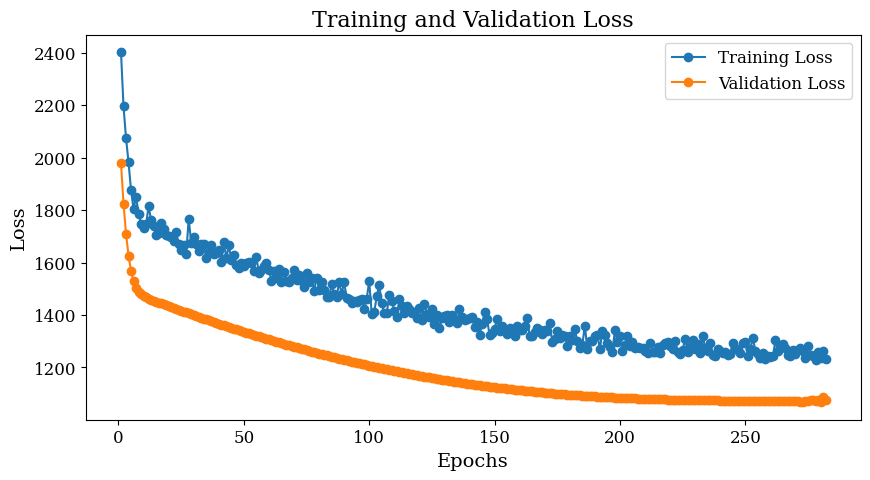

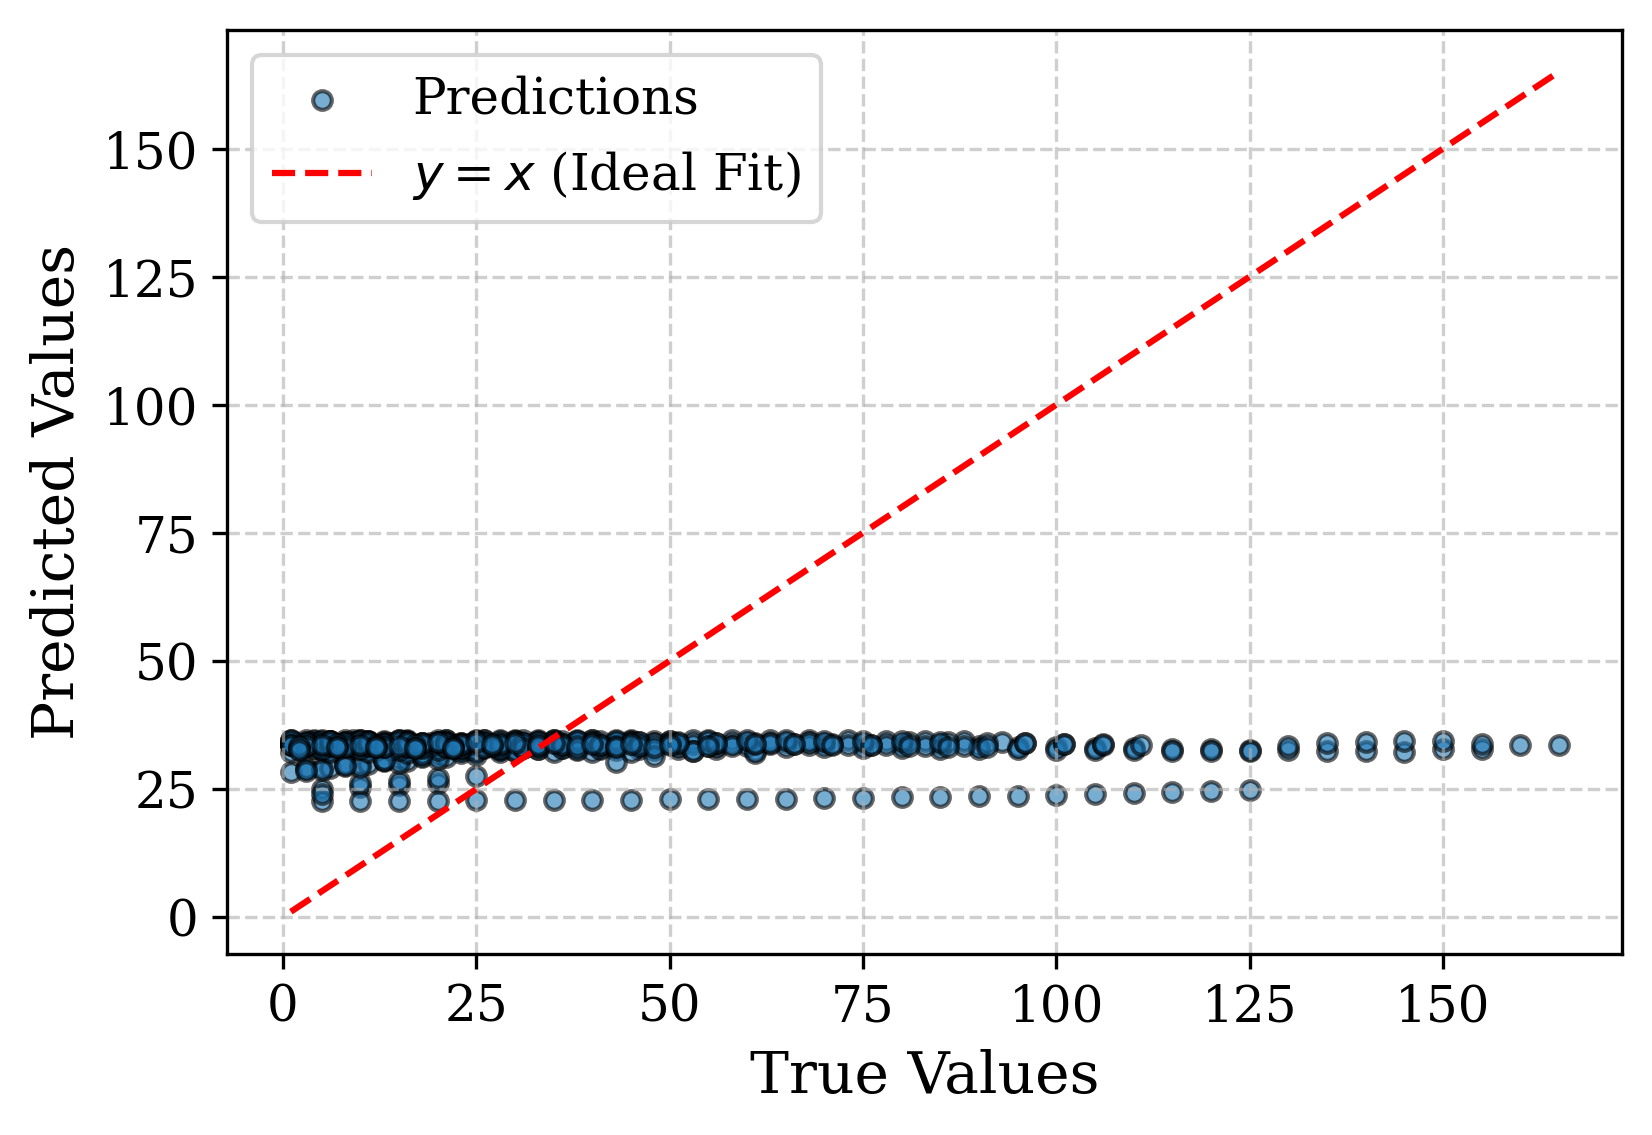

Evaluating motif 18 with size 24 and 358 indexes 
X_series shape: torch.Size([2974, 576, 2])
X_indices shape: torch.Size([2974, 20, 1])
X_mask shape: torch.Size([2974, 576])
y shape: torch.Size([2974, 1])
Best epoch: 74
Test Loss: 1275.4835205078125, Test MAE: 27.252063751220703, Test RMSE: 35.71391296386719
Best hyperparameters: {'learning_rate': 3.7000684190409526e-05, 'd_model': 512, 'n_heads': 2, 'e_layers': 2, 'dim_feedforward': 128, 'dropout': 0.20567818619439188, 'batch_size': 16}
Early stopping at epoch 85, with best epoch being 74


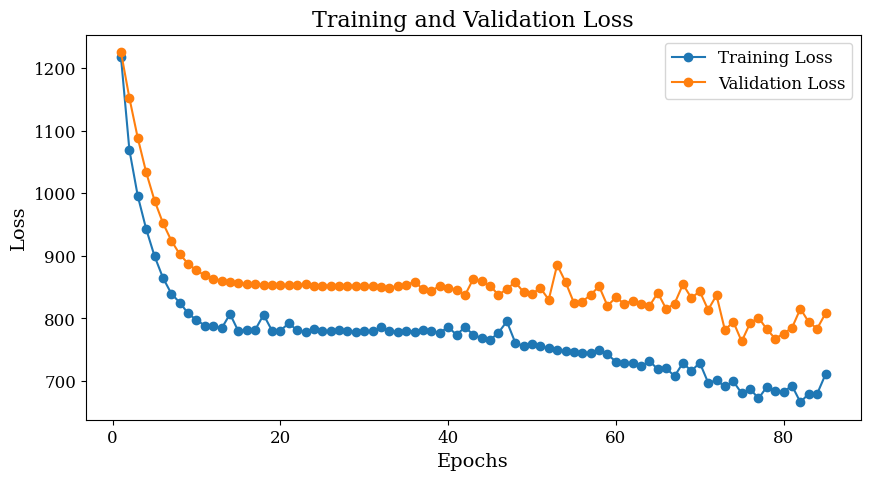

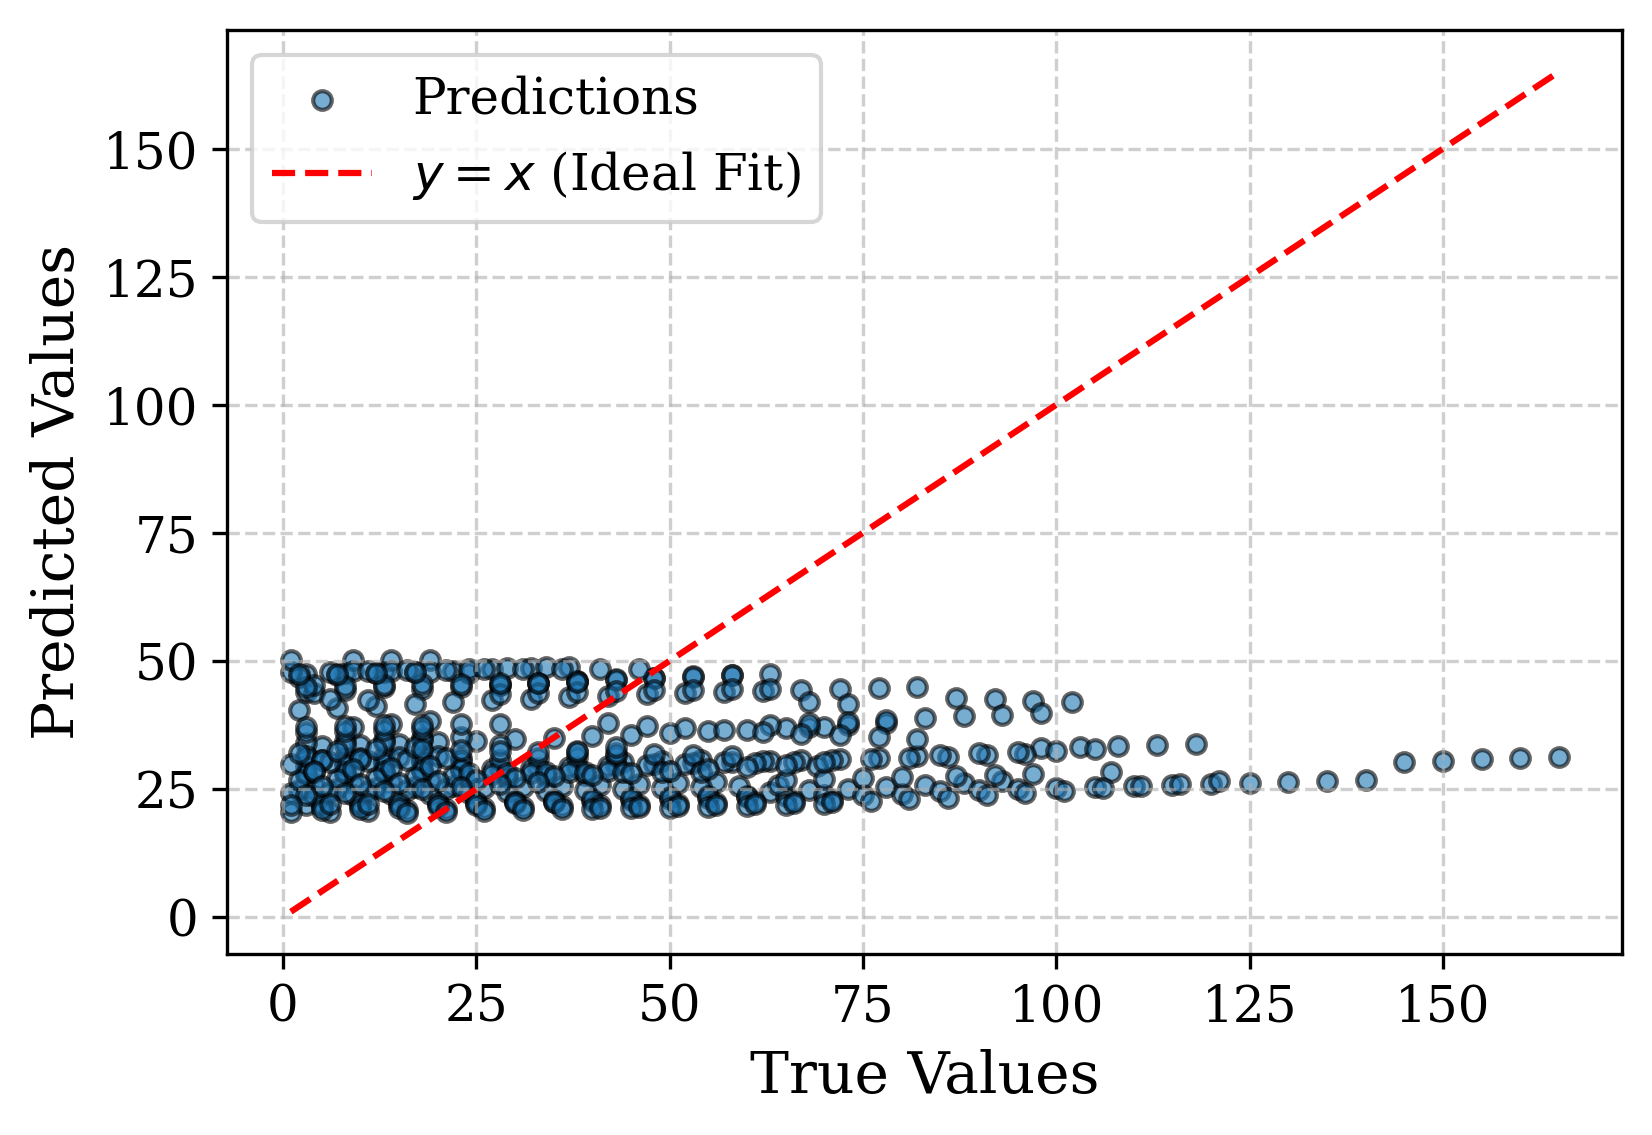

Evaluating motif 2 with size 24 and 298 indexes 
X_series shape: torch.Size([2987, 576, 2])
X_indices shape: torch.Size([2987, 17, 1])
X_mask shape: torch.Size([2987, 576])
y shape: torch.Size([2987, 1])
Best epoch: 26
Test Loss: 1229.703369140625, Test MAE: 29.3403263092041, Test RMSE: 35.0671272277832
Best hyperparameters: {'learning_rate': 0.00034065967304828474, 'd_model': 256, 'n_heads': 2, 'e_layers': 3, 'dim_feedforward': 256, 'dropout': 0.292391658050706, 'batch_size': 64}
Early stopping at epoch 37, with best epoch being 26


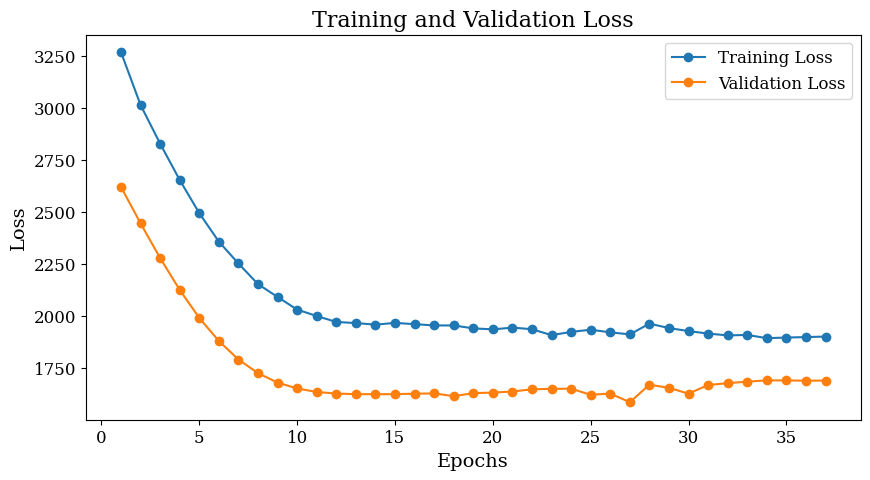

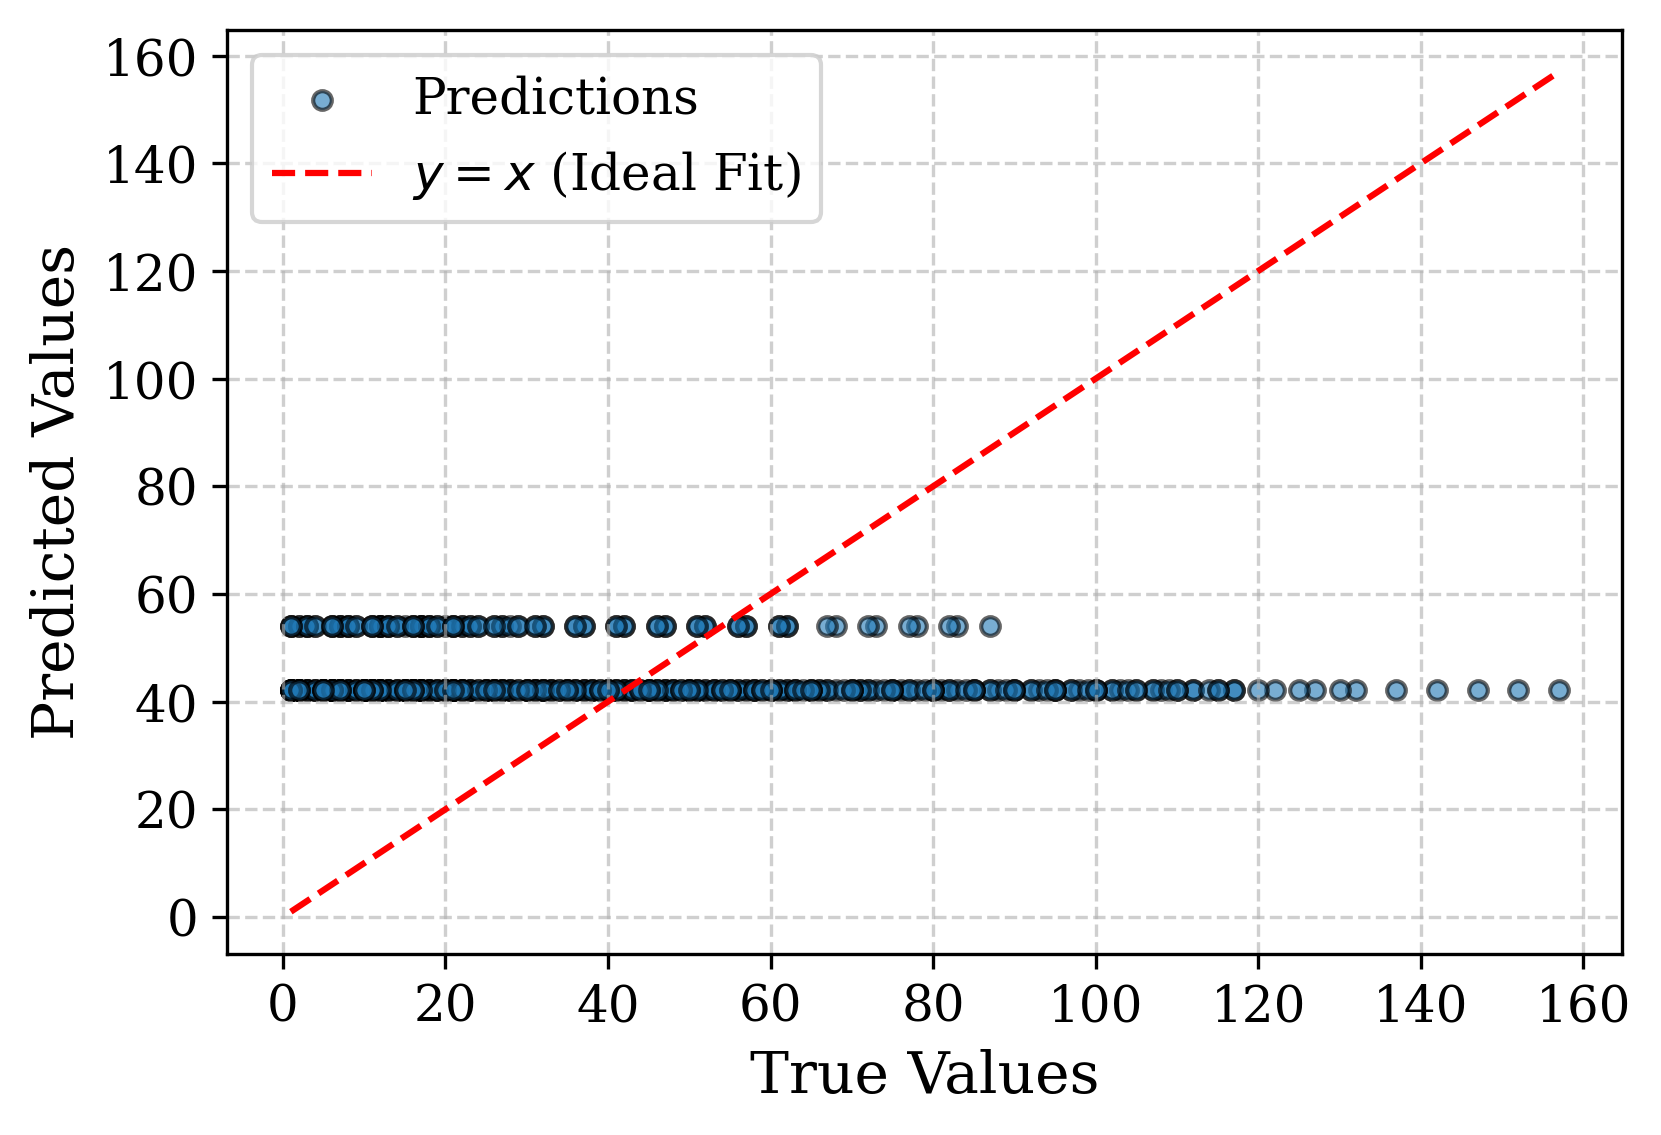

Evaluating motif 8 with size 24 and 279 indexes 
X_series shape: torch.Size([2984, 576, 2])
X_indices shape: torch.Size([2984, 22, 1])
X_mask shape: torch.Size([2984, 576])
y shape: torch.Size([2984, 1])
Best epoch: 155
Test Loss: 3253.967529296875, Test MAE: 44.74111557006836, Test RMSE: 57.04356002807617
Best hyperparameters: {'learning_rate': 2.770006658317284e-05, 'd_model': 512, 'n_heads': 16, 'e_layers': 2, 'dim_feedforward': 512, 'dropout': 0.4389681775291893, 'batch_size': 32}
Early stopping at epoch 166, with best epoch being 155


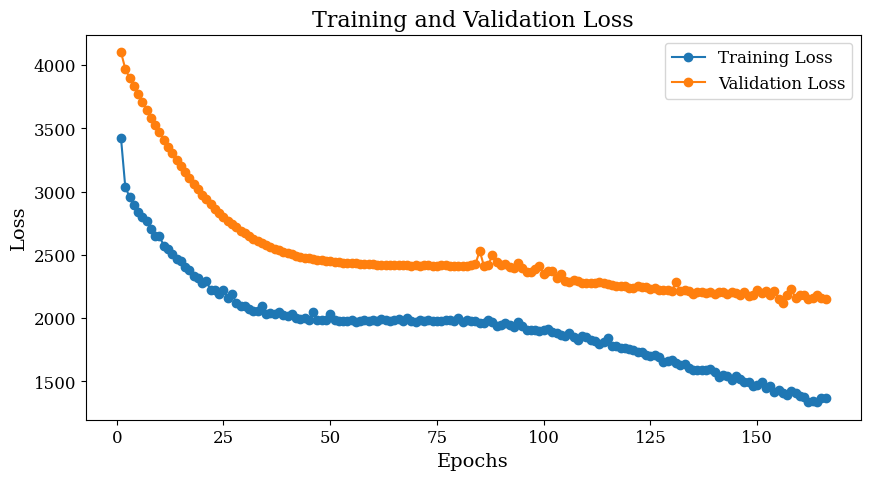

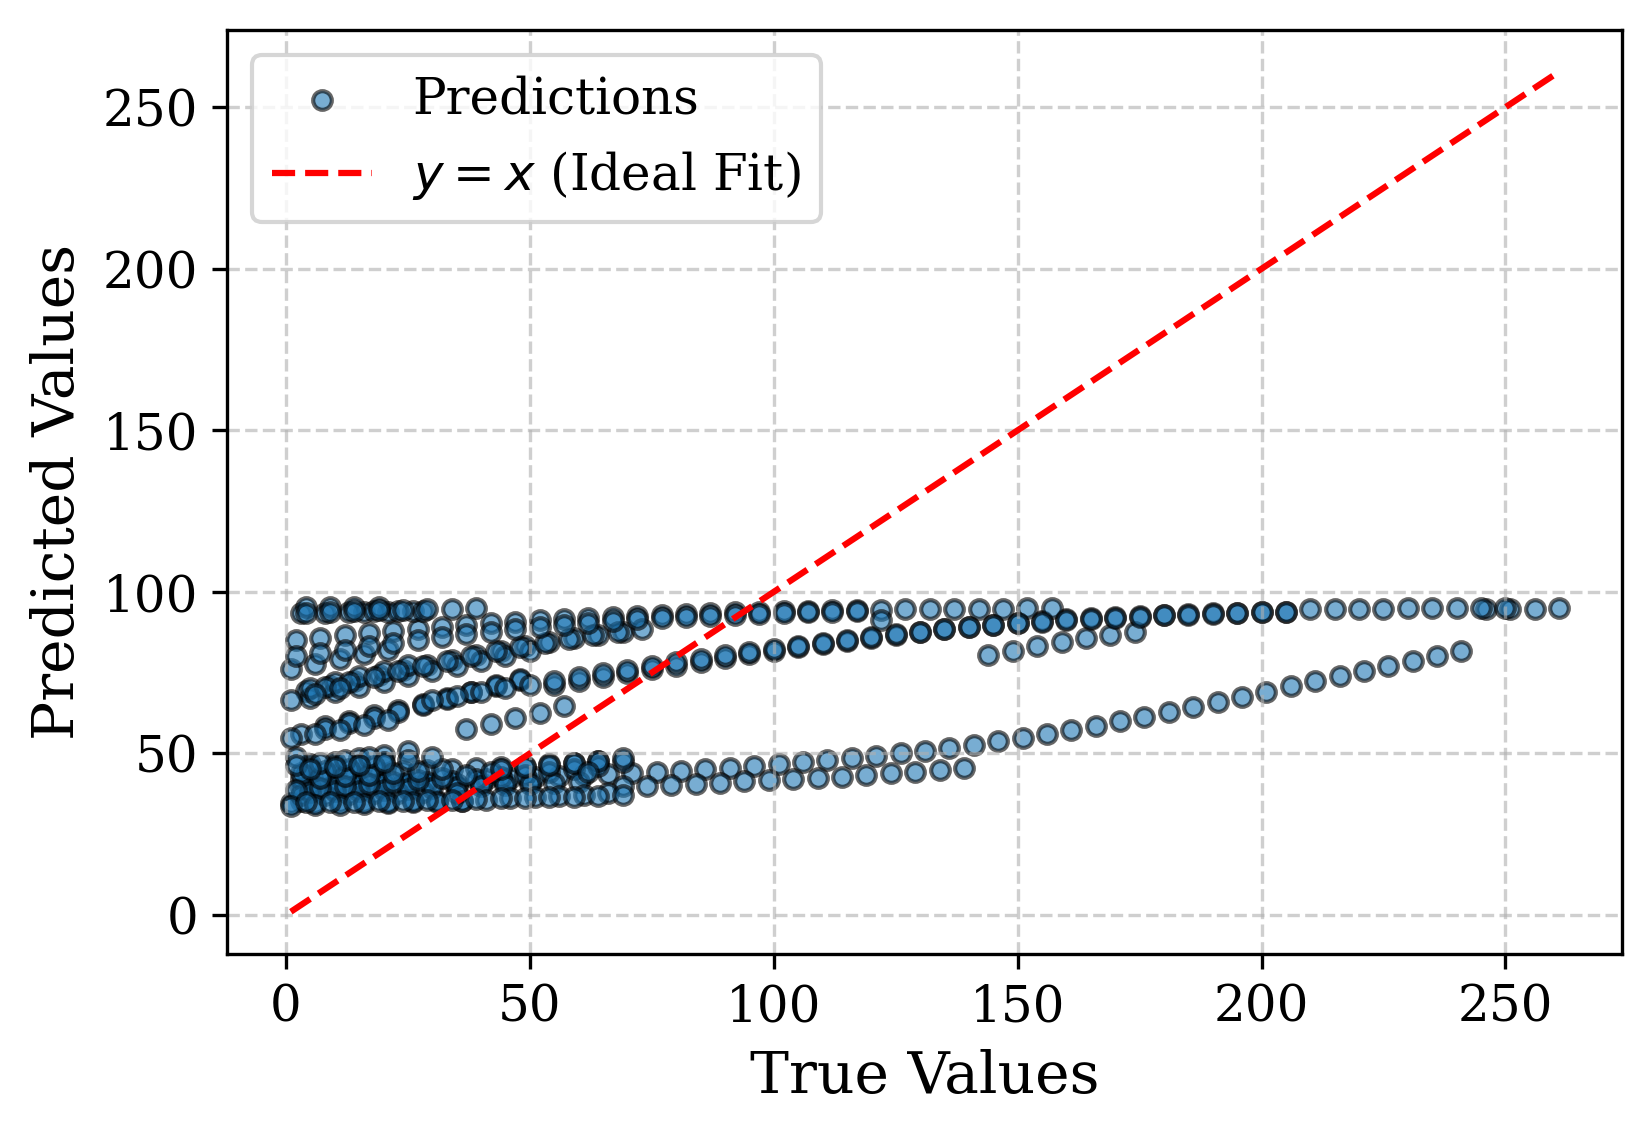

Evaluating motif 7 with size 24 and 268 indexes 
X_series shape: torch.Size([2887, 576, 2])
X_indices shape: torch.Size([2887, 25, 1])
X_mask shape: torch.Size([2887, 576])
y shape: torch.Size([2887, 1])
Best epoch: 246
Test Loss: 1677.7244873046875, Test MAE: 32.44290542602539, Test RMSE: 40.96003341674805
Best hyperparameters: {'learning_rate': 4.379977536719987e-05, 'd_model': 128, 'n_heads': 8, 'e_layers': 3, 'dim_feedforward': 256, 'dropout': 0.4978514015624918, 'batch_size': 32}
Early stopping at epoch 257, with best epoch being 246


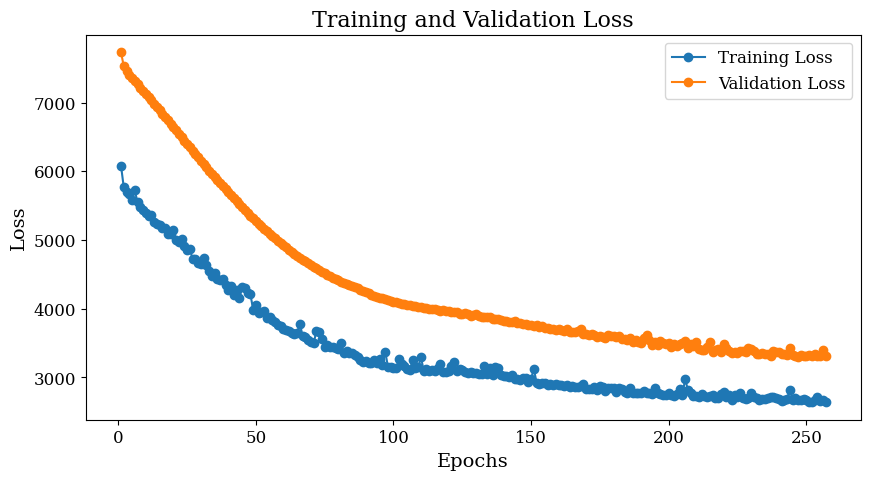

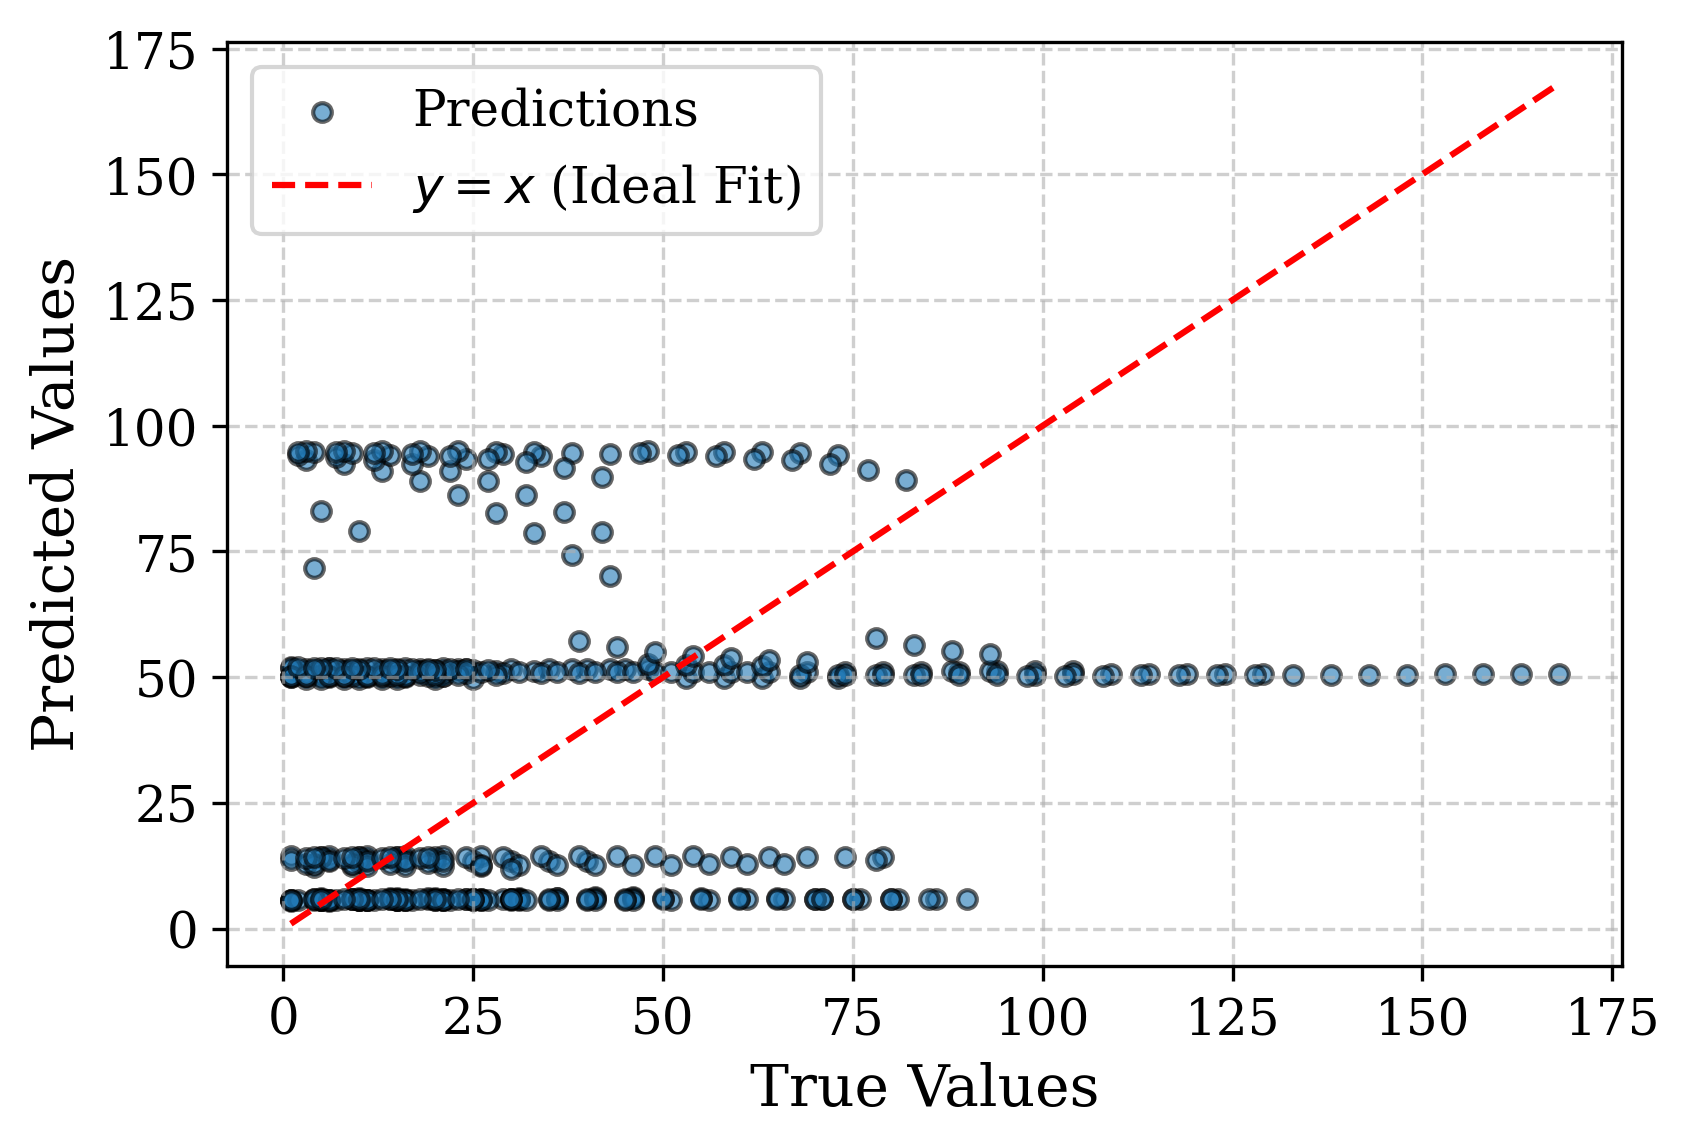

Aggregated Results Across Top 5 Motifs:
Mean Test Loss: 1744.0906982421875 ± 772.0614769389845
Mean Test MAE: 31.987109756469728 ± 6.72701709919271
Mean Test RMSE: 40.92232818603516 ± 8.333892250001089


In [11]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.transformer_pytorch import Transformer
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test


test_losses_list = []
test_mae_list = []
test_rmse_list = []

# Loop through each of the top 10 motifs
for i, top_motif in top_motifs.iterrows():

    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i+1} with size {MOTIF_SIZE} and {len(motif_indexes)} indexes ")
    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "Transformer"
    model_name = "TransformerIndexes"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3],
            "kwargs": {"log": True}
        },
        "d_model": {
            "type": "categorical",
            "args": [[64, 128, 256, 512]]
        },
        "n_heads": {
            "type": "categorical",
            "args": [[2, 4, 8, 16]]
        },
        "e_layers": {
            "type": "categorical",
            "args": [[1, 2, 3]]
        },
        "dim_feedforward": {
            "type": "categorical",
            "args": [[128, 256, 512]]
        },
        "dropout": {
            "type": "float",
            "args": [0.0, 0.5]
        },
        "batch_size": {
            "type": "categorical",
            "args": [[16, 32, 64, 128]]
        }
    }

    model_params_keys = ["d_model", "n_heads", "e_layers", "dim_feedforward", "dropout"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_indices": X_indices}
    #run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    # Plot predictions vs true values
    epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    plot_best_model_results_traindevtest( study.trials_dataframe(),
       save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    )    
    plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")
